# Introduction

$\newcommand{\G}{\mathcal{G}}$
$\newcommand{\V}{\mathcal{V}}$
$\newcommand{\E}{\mathcal{E}}$
$\newcommand{\R}{\mathbb{R}}$

This notebook shows how to apply our graph ConvNet ([paper] & [code]), or any other, to your structured or unstructured data. For this example, we assume that we have $n$ samples $x_i \in \R^{d_x}$ arranged in a data matrix $$X = [x_1, ..., x_n]^T \in \R^{n \times d_x}.$$ Each sample $x_i$ is associated with a vector $y_i \in \R^{d_y}$ for a regression task or a label $y_i \in \{0,\ldots,C\}$ for a classification task.

[paper]: https://arxiv.org/abs/1606.09375
[code]:  https://github.com/mdeff/cnn_graph

From there, we'll structure our data with a graph $\G = (\V, \E, A)$ where $\V$ is the set of $d_x = |\V|$ vertices, $\E$ is the set of edges and $A \in \R^{d_x \times d_x}$ is the adjacency matrix. That matrix represents the weight of each edge, i.e. $A_{i,j}$ is the weight of the edge connecting $v_i \in \V$ to $v_j \in \V$. The weights of that feature graph thus represent pairwise relationships between features $i$ and $j$. We call that regime **signal classification / regression**, as the samples $x_i$ to be classified or regressed are graph signals.

Other modelling possibilities include:
1. Using a data graph, i.e. an adjacency matrix $A \in \R^{n \times n}$ which represents pairwise relationships between samples $x_i \in \R^{d_x}$. The problem is here to predict a graph signal $y \in \R^{n \times d_y}$ given a graph characterized by $A$ and some graph signals $X \in \R^{n \times d_x}$. We call that regime **node classification / regression**, as we classify or regress nodes instead of signals.
2. Another problem of interest is whole graph classification, with or without signals on top. We'll call that third regime **graph classification / regression**. The problem here is to classify or regress a whole graph $A_i \in \R^{n \times n}$ (with or without an associated data matrix $X_i \in \R^{n \times d_x}$) into $y_i \in \R^{d_y}$. In case we have no signal, we can use a constant vector $X_i = 1_n$ of size $n$.

In [1]:
import os
os.environ['CUDA_VISABLE_DEVICES'] = '3'
from lib import models, graph, coarsening, utils
import numpy as np
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import scipy
import pandas as pd

In [3]:
adj = pd.read_hdf("../Benchmarks/Pilot1/RNAseqToSnp/cache/pos_genemania_combined_aligned_rnaseq_snp.hdf", key='adj')
x = pd.read_hdf("../Benchmarks/Pilot1/RNAseqToSnp/cache/pos_genemania_combined_aligned_rnaseq_snp.hdf", key='aligned_rnaseq')

In [4]:
x = x.reset_index()
x['Source'] = x.Sample.apply(lambda x : x.split(".")[0])
x = x[x.Source == 'CTRP']
x = x.set_index("Sample")

In [5]:
dose_repsonse = pd.read_table("../celsData/combined_single_response_agg")

/home/aclyde11/scratch-area/Benchmarks/venv/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
dose_repsonse = dose_repsonse[dose_repsonse.SOURCE == "CTRP"]
drugs = np.unique(dose_repsonse.DRUG)
dose_respomse_d = dose_repsonse[dose_repsonse.DRUG == 'CTRP.10']
dose_respomse_d = dose_respomse_d.set_index("CELL")

In [7]:
x = x.merge(pd.DataFrame(dose_respomse_d.AUC), left_index=True, right_index=True)
y = x.AUC
x = x.drop("AUC", axis=1)
x = x.drop("Source", axis=1)

(array([214.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 569.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

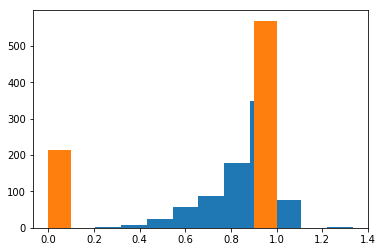

In [8]:
y_bin = np.digitize(y, bins=[0.8])
plt.hist(y)
plt.hist(y_bin)

# 1 Data

For the purpose of the demo, let's create a random data matrix $X \in \R^{n \times d_x}$ and somehow infer a label $y_i = f(x_i)$.

In [9]:
d = x.shape[1]    # Dimensionality.
n = x.shape[0]  # Number of samples.
c = y_bin.size      # Number of feature communities.

# Data matrix, structured in communities (feature-wise).
X = np.array(x, dtype=np.float32)


# Classification.
y = y_bin

Then split this dataset into training, validation and testing sets.

In [10]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y_bin, stratify=y_bin, train_size=0.85)

/home/aclyde11/scratch-area/Benchmarks/venv/local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# 2 Graph

The second thing we need is a **graph between features**, i.e. an adjacency matrix $A \in \mathbb{R}^{d_x \times d_x}$.
Structuring data with graphs is very flexible: it can accomodate both structured and unstructured data.
1. **Structured data**.
    1. The data is structured by an Euclidean domain, e.g. $x_i$ represents an image, a sound or a video. We can use a classical ConvNet with 1D, 2D or 3D convolutions or a graph ConvNet with a line or grid graph (however losing the orientation).
    2. The data is structured by a graph, e.g. the data lies on a transportation, energy, brain or social network.
2. **Unstructured data**. We could use a fully connected network, but the learning and computational complexities are gonna be large. An alternative is to construct a sparse similarity graph between features (or between samples) and use a graph ConvNet, effectively structuring the data and drastically reducing the number of parameters through weight sharing. As for classical ConvNets, the number of parameters are independent of the input size.

There are many ways, supervised or unsupervised, to construct a graph given some data. And better the graph, better the performance ! For this example we'll define the adjacency matrix as a simple similarity measure between features. Below are the choices one has to make when constructing such a graph.
1. The distance function. We'll use the Euclidean distance $d_{ij} = \|x_i - x_j\|_2$.
2. The kernel. We'll use the Gaussian kernel $a_{ij} = \exp(d_{ij}^2 / \sigma^2)$.
3. The type of graph. We'll use a $k$ nearest neigbors (kNN) graph.

In [15]:
#filter graph
thresh = 0.4
A = np.array(adj.values, dtype=np.float32) - thresh
A = adj.values * (adj.values > 0)

In [16]:
A=scipy.sparse.csr.csr_matrix(A)
assert A.shape == (d, d)

print('d = |V| = {}, k|V| < |E| = {}'.format(d, A.nnz))
#plt.spy(A, markersize=0.1, color='black');

d = |V| = 11961, k|V| < |E| = 6082468


In [17]:
A.nnz

6082468

To be able to pool graph signals, we need first to coarsen the graph, i.e. to find which vertices to group together. At the end we'll have multiple graphs, like a pyramid, each at one level of resolution. The finest graph is where the input data lies, the coarsest graph is where the data at the output of the graph convolutional layers lie. That data, of reduced spatial dimensionality, can then be fed to a fully connected layer.

The parameter here is the number of times to coarsen the graph. Each coarsening approximately reduces the size of the graph by a factor two. Thus if you want a pooling of size 4 in the first layer followed by a pooling of size 2 in the second, you'll need to coarsen $\log_2(4+2) = 3$ times.

After coarsening we rearrange the vertices (and add fake vertices) such that pooling a graph signal is analog to pooling a 1D signal. See the [paper] for details.

[paper]: https://arxiv.org/abs/1606.09375

In [ ]:
graphs, perm = coarsening.coarsen(A, levels=3, self_connections=True)

In [ ]:
X_train = coarsening.perm_data(X_train, perm)
X_test = coarsening.perm_data(X_test, perm)

We finally need to compute the graph Laplacian $L$ for each of our graphs (the original and the coarsened versions), defined by their adjacency matrices $A$. The sole parameter here is the type of Laplacian, e.g. the combinatorial Laplacian, the normalized Laplacian or the random walk Laplacian.

In [ ]:
L = [graph.laplacian(A, normalized=True) for A in graphs]
#graph.plot_spectrum(L)

# 3 Graph ConvNet

Here we apply the graph convolutional neural network to signals lying on graphs. After designing the architecture and setting the hyper-parameters, the model takes as inputs the data matrix $X$, the target $y$ and a list of graph Laplacians $L$, one per coarsening level.

The data, architecture and hyper-parameters are absolutely *not engineered to showcase performance*. Its sole purpose is to illustrate usage and functionality.

In [ ]:
params = dict()
params['dir_name']       = 'rna_pred'
params['num_epochs']     = 50
params['batch_size']     = 2
params['eval_frequency'] = 200

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = y.max() + 1

# Architecture.
params['F']              = [32, 16, 4]  # Number of graph convolutional filters.
params['K']              = [5, 5, 5]  # Polynomial orders.
params['p']              = [2, 2, 2]    # Pooling sizes.
params['M']              = [50, 30, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 0
params['dropout']        = 0
params['learning_rate']  = 0.001
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = X_train.shape[0] / params['batch_size']

In [ ]:
model = models.cgcnn(L, **params)
print(model.graph)

In [ ]:
accuracy, loss, t_step = model.fit(X_train, y_train, X_test, y_test)

# 4 Evaluation

We often want to monitor:
1. The convergence, i.e. the training loss and the classification accuracy on the validation set.
2. The performance, i.e. the classification accuracy on the testing set (to be compared with the training set accuracy to spot overfitting).

The `model_perf` class in [utils.py](utils.py) can be used to compactly evaluate multiple models.

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(accuracy, 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(loss, 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()

In [ ]:
print('Time per step: {:.2f} ms'.format(t_step*1000))

In [ ]:
res = model.evaluate(X_test, y_test)
print(res[0])